# Basic Models Experiment

Use the new processed dataset called `hotel_bookings_processed.csv`

In [2]:
import time

import numpy as np
import pandas as pd
import datetime as dt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_roc_curve
# import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Basic models
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
# from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = "/content/drive/Shareddrives/CIS 520/final project/hotel_bookings_processed.csv"
data = pd.read_csv(path)
data

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BGR,country_BHR,country_BHS,...,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,day_of_week,day_of_year,is_family,customer_number,night_number
0,0,342,2015,7,27,1,0,0,2,0.0,0,0,0,0,3,0.0,0.0,0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,182,0,2.0,0
1,0,737,2015,7,27,1,0,0,2,0.0,0,0,0,0,4,0.0,0.0,0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,182,0,2.0,0
2,0,7,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,0.0,0.0,0,75.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3,183,0,1.0,1
3,0,13,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,304.0,0.0,0,75.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3,183,0,1.0,1
4,0,14,2015,7,27,1,0,2,2,0.0,0,0,0,0,0,240.0,0.0,0,98.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4,184,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,8,35,31,2,8,2,1.0,0,0,0,0,1,143.0,0.0,0,89.75,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,6,253,1,3.0,10
40056,0,169,2017,8,35,30,2,9,2,0.0,0,0,0,0,0,250.0,0.0,0,202.27,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,6,253,0,2.0,11
40057,0,204,2017,8,35,29,4,10,2,0.0,0,0,0,0,0,250.0,0.0,0,153.57,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,255,0,2.0,14
40058,0,211,2017,8,35,31,4,10,2,0.0,0,0,0,0,0,40.0,0.0,0,112.80,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,257,0,2.0,14


In [ ]:
data.corr()['is_canceled'].abs().sort_values(ascending=False)[1:11]

deposit_type_Non Refund        0.322567
deposit_type_No Deposit        0.305978
country_PRT                    0.285592
required_car_parking_spaces    0.243863
lead_time                      0.229444
day_of_week                    0.171971
market_segment_Online TA       0.148792
country_GBR                    0.148477
assigned_room_type_A           0.148192
market_segment_Direct          0.140526
Name: is_canceled, dtype: float64

In [6]:
## Initialize X, y and split dataset
df = data.copy()
y = df['is_canceled']
X = df.drop(['is_canceled'], axis=1)
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.20, random_state=42)

Text(0.5, 0, 'Top 20 Feature Importance (%)')

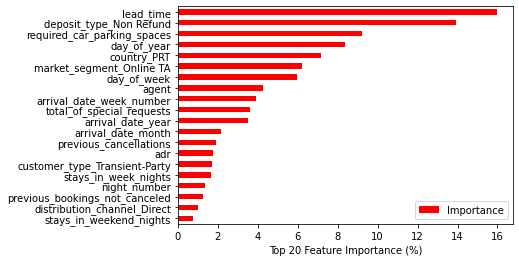

In [ ]:
clf_rf = DecisionTreeClassifier(max_depth=12).fit(X_train, y_train)
pd.DataFrame(data = clf_rf.feature_importances_ * 100, 
             columns = ['Importance'], 
             index = X_train.columns)\
                .sort_values('Importance', ascending=True)[-20:]\
                .plot(kind='barh', color='r')

plt.xlabel("Top 20 Feature Importance (%)")

## Imbalance

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
def sampler_compare(samplers):

    accus, accu_balanceds = [], []

    for sampler in samplers.values():
        X_train_balanced, y_train_balanced = sampler.fit_sample(X_train, y_train)
        ## Test by logistic regression accuracy
        logit = LogisticRegression(solver='liblinear')
        clf = logit.fit(X_train, y_train)
        accu = roc_auc_score(y_test, clf.predict(X_test))
        clf_balanced = logit.fit(X_train_balanced, y_train_balanced)
        accu_balanced = roc_auc_score(y_test, clf.predict(X_test))

        accus.append(accu)
        accu_balanceds.append(accu_balanced)

    return accus, accu_balanceds

In [ ]:
samplers = {'Undersample': RandomUnderSampler(random_state=0),
           'Oversample': RandomOverSampler(random_state=0),
           'SMOTE': SMOTE()}
accus, accu_balanceds = np.round(sampler_compare(samplers), 4)

In [ ]:
## Output comparsion table
table = pd.DataFrame({"Balancing Method": samplers.keys(), 
                      "Accuracy (imbalanced)": accus, 
                      "Accuracy (balanced)": accu_balanceds})

pd.pivot_table(table, index=['Balancing Method'])\
    .sort_values(by="Accuracy (balanced)", ascending=False)

,Accuracy (balanced),Accuracy (imbalanced)
Balancing Method,,
SMOTE,0.8401,0.8028
Oversample,0.8387,0.8028
Undersample,0.8379,0.8028


In [ ]:
print(pd.pivot_table(table, index=['Balancing Method'])\
    .sort_values(by="Accuracy (balanced)", ascending=False).to_latex())

It's obvious that the balancing method can imporve the accuracy and among them, SMOTE preforms the best, thus we deploy the SMOTE on the train set.

In [8]:
X_train_balanced, y_train_balanced = SMOTE().fit_sample(X_train, y_train)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(46280, 194)
(46280,)


## Basic Models Implementation

### Tuning 

#### Random Forest

In [ ]:
# rf_para = {'n_estimators': [int(x) for x in np.linspace(200, 2000, num=10)],
#            'max_features': ['auto', 'sqrt'],
#            'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
#            'min_samples_split': [2, 5, 10],
#            'bootstrap': [True, False]}
rf_para = {'n_estimators': [100, 200, 500],
           'max_features': ['auto', 'sqrt', 'log2'],
           'min_samples_split': [2, 5, 10]}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, rf_para, cv=10, n_jobs=-1, verbose=2)
rf_cv.fit(X_test[:1000], y_test[:1000])
# rf_cv.fit(X_test, y_test)
print("Best paramters (RF): {}".format(rf_cv.best_params_))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.2min finished


Best paramters (RF): {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}


Best paramters (RF): {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

#### Support Vector Machine

In [ ]:
svm_para = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [50, 10, 1.0, 0.1, 0.01],
            'gamma': ['scale']}

svm = SVC()
nn_cv = GridSearchCV(svm, svm_para, cv=10, n_jobs=-1, verbose=2)
nn_cv.fit(X_test[:1000], y_test[:1000])
# nn_cv.fit(X_test, y_test)
print("Best paramters (SVM): {}".format(nn_cv.best_params_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.3min finished


Best paramters (SVM): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Best paramters (SVM): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

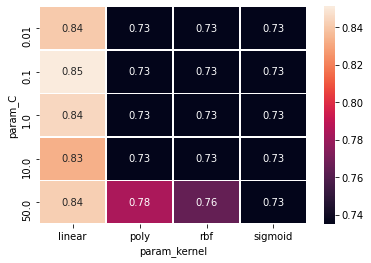

In [ ]:
## Visualize by heatmap
pvt = pd.pivot_table(pd.DataFrame(nn_cv.cv_results_),
                     values='mean_test_score',
                     index='param_C',
                     columns='param_kernel')
ax = sns.heatmap(pvt, annot=True, linewidths=.5)

#### Neural Netowrk

In [ ]:
nn_para = {'alpha': [1, 0.1, 0.01, 0.001],
           'hidden_layer_sizes': [(50,50,50), (100,100)],
           'solver': ["adam", "sgd"],
           'activation': ["logistic", "relu"]}

nn = MLPClassifier()
nn_cv = GridSearchCV(nn, nn_para, cv=10, n_jobs=-1, verbose=2)
nn_cv.fit(X_test, y_test)
print("Best paramters (NN): {}".format(nn_cv.best_params_))

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 36.0min finished


Best paramters (NN): {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}


Best paramters (NN): {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}

### All Models Comparison

Notes: SVC runs very slowly due to the fact of its complexity $\mathcal{O}(n^2 p)$ ([source](https://stackoverflow.com/questions/40077432/why-is-scikit-learn-svm-svc-extremely-slow))

In [9]:
def compute(name, model, X_train, X_test, y_train, y_test):

    fpr, tpr = [], []
    accu = auc = exectime = 0

    start = time.process_time()
    clf = model.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    exectime = round(time.process_time() - start, 4)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    accu = round(accuracy_score(y_test,y_pred), 4)
    auc = round(roc_auc_score(y_test, y_prob), 4)
    cm = confusion_matrix(y_test, y_pred)

    ## Plot accuracy, AUC and confusion matrix 
    print("# {}:\nAccuracy Score: {}\nAUC Score: {}\nConfusion Matrix:\n{}"
            .format(name, accu, auc, cm))
    print("-------------------- \n")

    return fpr, tpr, accu, auc, exectime

def implement(models, X_train, X_test, y_train, y_test, balanced=False):

    accus, aucs, times, fprs, tprs = [], [], [], [], []

    for name, model in models.items():
    
        ## XGBoost requires the same column number of training and test set
        if name == "XGBoost" and balanced == True:
            X_test_balanced, y_test_balanced = SMOTE().fit_sample(X_test, y_test)
            fpr, tpr, accu, auc, exectime = \
                compute(name, model, X_train, X_test_balanced, y_train, y_test_balanced)
        ## Neural Network prefers standardization
        elif name == "Neural Network (vanilla)" or "Neural Network (tuned)":
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            fpr, tpr, accu, auc, exectime = \
                compute(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
        else:
            fpr, tpr, accu, auc, exectime = \
                compute(name, model, X_train, X_test, y_train, y_test)
      
        fprs.append(fpr)
        tprs.append(tpr)
        times.append(exectime)
        accus.append(accu)
        aucs.append(auc)
        
    return accus, aucs, times, fprs, tprs

def plot_ROC(fprs, tprs, aucs, names):

    plt.figure(0).clf()

    for fpr, tpr, name, auc in zip(fprs, tprs, names, aucs):
        plt.plot(fpr, tpr, label=name+" (AUC="+str(auc)+")")

    ## Plot ROC comparison
    plt.legend(loc=0)
    plt.title("Comparison of Models by ROC")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")

In [10]:
## Dictionary: {model name -- classifier}
models = \
{"Logistic Regression (baseline)": LogisticRegression(solver='liblinear'),
 "Decisioion Tree": DecisionTreeClassifier(max_depth=12),
 "Random Forest (vanilla)": RandomForestClassifier(),
 "Random Forest (Tuned)": RandomForestClassifier(max_features='sqrt',
                                                 min_samples_split=2,
                                                 n_estimators=500),
 "Extra Trees": ExtraTreesClassifier(min_samples_leaf=7,
                                     min_samples_split=2,
                                     n_estimators=500),
 "Neural Network (vanilla)": MLPClassifier(),
 "Neural Network (Tuned)": MLPClassifier(alpha=0.001, 
                                         hidden_layer_sizes=(100,100),
                                         solver='adam',
                                         activation='logistic'), 
#  "Gaussian Naive Bayes": GaussianNB(),
 "XGBoost": XGBClassifier(),
 "AdaBoost": AdaBoostClassifier(n_estimators=500),
 "SVM (Tuned)": SVC(kernel='linear', C=0.1, probability=True)}

Imbalanced Training and Plot

In [11]:
accus, aucs, times, fprs, tprs = implement(models, X_train, X_test, y_train, y_test, False)

# Logistic Regression (baseline):
Accuracy Score: 0.8663
AUC Score: 0.9226
Confusion Matrix:
[[5403  395]
 [ 676 1538]]
-------------------- 

# Decisioion Tree:
Accuracy Score: 0.9217
AUC Score: 0.9619
Confusion Matrix:
[[5516  282]
 [ 345 1869]]
-------------------- 

# Random Forest (vanilla):
Accuracy Score: 0.9458
AUC Score: 0.9853
Confusion Matrix:
[[5707   91]
 [ 343 1871]]
-------------------- 

# Random Forest (Tuned):
Accuracy Score: 0.9467
AUC Score: 0.9863
Confusion Matrix:
[[5709   89]
 [ 338 1876]]
-------------------- 

# Extra Trees:
Accuracy Score: 0.8812
AUC Score: 0.9527
Confusion Matrix:
[[5686  112]
 [ 840 1374]]
-------------------- 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



# Neural Network (vanilla):
Accuracy Score: 0.9705
AUC Score: 0.9868
Confusion Matrix:
[[5697  101]
 [ 135 2079]]
-------------------- 

# Neural Network (Tuned):
Accuracy Score: 0.9725
AUC Score: 0.9885
Confusion Matrix:
[[5748   50]
 [ 170 2044]]
-------------------- 

# XGBoost:
Accuracy Score: 0.9096
AUC Score: 0.9648
Confusion Matrix:
[[5584  214]
 [ 510 1704]]
-------------------- 

# AdaBoost:
Accuracy Score: 0.8938
AUC Score: 0.9494
Confusion Matrix:
[[5480  318]
 [ 533 1681]]
-------------------- 

# SVM (Tuned):
Accuracy Score: 0.8665
AUC Score: 0.9204
Confusion Matrix:
[[5423  375]
 [ 695 1519]]
-------------------- 



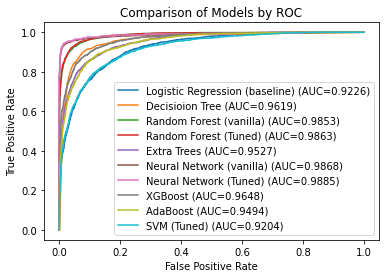

In [12]:
plot_ROC(fprs, tprs, aucs, models.keys())

Balanced Training and Plot

In [13]:
accus_b, aucs_b, times_b, fprs_b, tprs_b = \
    implement(models, X_train_balanced, X_test, y_train_balanced, y_test, True)

# Logistic Regression (baseline):
Accuracy Score: 0.8361
AUC Score: 0.9218
Confusion Matrix:
[[4822  976]
 [ 337 1877]]
-------------------- 

# Decisioion Tree:
Accuracy Score: 0.9146
AUC Score: 0.9555
Confusion Matrix:
[[5384  414]
 [ 270 1944]]
-------------------- 

# Random Forest (vanilla):
Accuracy Score: 0.9447
AUC Score: 0.9839
Confusion Matrix:
[[5669  129]
 [ 314 1900]]
-------------------- 

# Random Forest (Tuned):
Accuracy Score: 0.9441
AUC Score: 0.9848
Confusion Matrix:
[[5672  126]
 [ 322 1892]]
-------------------- 

# Extra Trees:
Accuracy Score: 0.8922
AUC Score: 0.9527
Confusion Matrix:
[[5303  495]
 [ 369 1845]]
-------------------- 

# Neural Network (vanilla):
Accuracy Score: 0.9614
AUC Score: 0.9833
Confusion Matrix:
[[5656  142]
 [ 167 2047]]
-------------------- 

# Neural Network (Tuned):
Accuracy Score: 0.9672
AUC Score: 0.9889
Confusion Matrix:
[[5693  105]
 [ 158 2056]]
-------------------- 

# XGBoost:
Accuracy Score: 0.9308
AUC Score: 0.9833
Confusion M

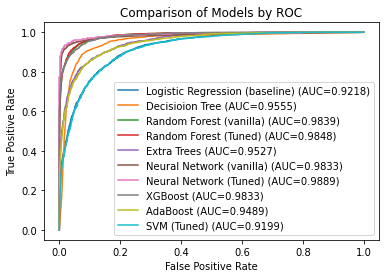

In [14]:
plot_ROC(fprs_b, tprs_b, aucs_b, models.keys())

Text(0.5, 0, 'Runtime Comparison (s)')

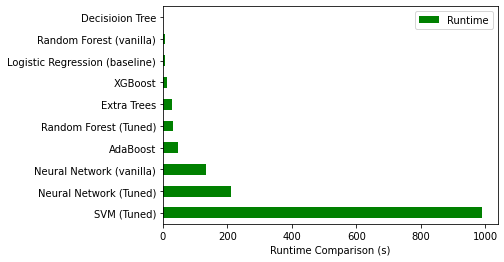

In [15]:
## Plot runtime comparison
pd.DataFrame(data=times, columns=['Runtime'], index=models.keys())\
                .sort_values('Runtime', ascending=False)\
                .plot(kind='barh', color='g')

plt.xlabel("Runtime Comparison (s)")

In [16]:
## Output comparsion table
table = pd.DataFrame({"Model": models.keys(), 
                      "Accuracy": accus, 
                      "AUC": aucs,
                      "Runtime(s)": times,
                      "Accuracy_B": accus_b, 
                      "AUC_B": aucs_b,
                      "Runtime_B(s)": times_b})

pd.pivot_table(table, index=['Model'])\
    .sort_values(by="Accuracy", ascending=False)

,AUC,AUC_B,Accuracy,Accuracy_B,Runtime(s),Runtime_B(s)
Model,,,,,,
Neural Network (Tuned),0.9885,0.9889,0.9725,0.9672,209.7754,253.2274
Neural Network (vanilla),0.9868,0.9833,0.9705,0.9614,132.9359,125.3403
Random Forest (Tuned),0.9863,0.9848,0.9467,0.9441,32.1794,54.7000
Random Forest (vanilla),0.9853,0.9839,0.9458,0.9447,6.3899,11.2010
Decisioion Tree,0.9619,0.9555,0.9217,0.9146,0.5261,1.3537
XGBoost,0.9648,0.9833,0.9096,0.9308,13.4476,20.0968
AdaBoost,0.9494,0.9489,0.8938,0.8949,47.5919,102.2639
Extra Trees,0.9527,0.9527,0.8812,0.8922,27.0275,44.5968
SVM (Tuned),0.9204,0.9199,0.8665,0.8326,989.7524,2564.1543


Compare the accuracy difference among models and balance/imbalance.

In [ ]:
print(pd.pivot_table(table, index=['Model'])\
    .sort_values(by="Accuracy", ascending=False).to_latex())

## Ensemble by Soft Voting

Selected the most accurate ones to combine as a new multi-layor voting classifier. See notebooks "Advanced Models Exploration"